In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import string

import nltk
from nltk.tokenize import TreebankWordTokenizer, word_tokenize
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

import mglearn

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from IPython.lib.display import Audio


In [3]:
df = pd.read_csv('data/tweet_data.csv')

In [4]:
df.head()

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,photoUrl,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,videoUrl
0,1070867471245164544,2018-12-07 02:27:55,-1,-1,98,False,True,False,64,https://pbs.twimg.com/media/Dtx8SiIWkAImVsb.jpg,34,-1,The immediate impulse for an alliance of the E...,Business,23464532,5988062,The Economist,NaN
1,1070868017888837633,2018-12-07 02:30:05,-1,-1,13,False,True,False,10,https://pbs.twimg.com/media/Dtx8yTyW4AEciqP.jpg,3,-1,America's economy is flashing some warning sig...,Business,1732809,16184358,CNN Business,NaN
2,1070868012864028673,2018-12-07 02:30:04,-1,-1,12,False,True,False,8,NaN,4,-1,Lyft files for what is expected to be one of t...,Business,2253989,25053299,FORTUNE,NaN
3,1070867995239555075,2018-12-07 02:30:00,-1,-1,5,False,True,False,4,NaN,1,-1,"Exporters still waiting to get Rs 6,000 crore ...",Business,1704056,43855487,Business Standard,NaN
4,1070867995205885952,2018-12-07 02:30:00,-1,-1,5,False,True,False,2,NaN,3,-1,Ride-hailing firm Lyft races to leave Uber beh...,Business,1997662,15110357,Reuters Business,https://video.twimg.com/amplify_video/10708116...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785916 entries, 0 to 785915
Data columns (total 18 columns):
tweetID       785916 non-null int64
crDate        785916 non-null object
edInput       785916 non-null int64
editor        785916 non-null int64
engages       785916 non-null int64
isApproved    785916 non-null bool
isEdNeed      785916 non-null bool
isRT          785916 non-null bool
likes         785916 non-null int64
photoUrl      277896 non-null object
retweets      785916 non-null int64
rtUsID        785916 non-null int64
text          785916 non-null object
topicName     785916 non-null object
usFlwrs       785916 non-null int64
usID          785916 non-null int64
usName        785916 non-null object
videoUrl      140491 non-null object
dtypes: bool(3), int64(9), object(6)
memory usage: 92.2+ MB


In [6]:
df.describe()

,tweetID,edInput,editor,engages,likes,retweets,rtUsID,usFlwrs,usID
count,7.859160e+05,785916.000000,785916.000000,7.859160e+05,7.859160e+05,7.859160e+05,7.859160e+05,7.859160e+05,7.859160e+05
mean,1.115213e+18,0.206035,2311.963123,1.403637e+03,1.085909e+03,3.177282e+02,4.365098e+16,4.472701e+06,1.085276e+17
std,2.925292e+16,1.439867,2495.158883,1.665960e+04,1.293993e+04,4.053267e+03,1.894384e+17,9.149778e+06,3.010486e+17
min,5.354500e+04,-1.000000,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,1.200000e+01
25%,1.095791e+18,-1.000000,-1.000000,2.300000e+01,1.600000e+01,6.000000e+00,-1.000000e+00,1.426280e+05,1.551377e+07
50%,1.116465e+18,-1.000000,-1.000000,6.400000e+01,4.500000e+01,1.800000e+01,-1.000000e+00,9.668265e+05,3.618422e+07
75%,1.137676e+18,1.000000,5003.000000,2.500000e+02,1.840000e+02,6.500000e+01,-1.000000e+00,3.603135e+06,9.545908e+08
max,1.154179e+18,4.000000,5101.000000,4.152927e+06,3.206434e+06,1.335638e+06,1.108957e+18,1.057384e+08,1.153467e+18


In [7]:
df.columns

Index(['tweetID', 'crDate', 'edInput', 'editor', 'engages', 'isApproved',
       'isEdNeed', 'isRT', 'likes', 'photoUrl', 'retweets', 'rtUsID', 'text',
       'topicName', 'usFlwrs', 'usID', 'usName', 'videoUrl'],
      dtype='object')

In [8]:
df['topicName'].unique()

array(['Business', 'Animal', 'Memes', 'Nature', 'Travel', 'Interesting',
       'News', 'Fashion', 'Art', 'Personal Development', 'Motivational',
       'DIY & Craft', 'Editorial Pics', 'Funny', 'Poem', 'World Leaders',
       'Entrepreneurship', 'US News', 'Journalists', 'Flowers',
       'Cryptocurrency', 'Photography', 'Design & Architecture',
       'Fitness', 'Spirituality', 'Startup', 'Space', 'Technology',
       'Digital Media & Internet', 'Psychology', 'Science', 'Basketball',
       'Humor', 'Mindfulness', 'Medical', 'Informative', 'Love', 'Stocks',
       'Nanotech', 'Biotech', 'science', 'Random'], dtype=object)

In [9]:
df_nature = df[df['topicName']=='Nature']

In [10]:
df_nature.head()

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,photoUrl,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,videoUrl
44,1070875544202432514,2018-12-07 03:00:00,-1,-1,44,False,True,False,33,https://pbs.twimg.com/media/DtuIrMXWoAA5Wve.jpg,11,-1,"Lack Lake, Rocky mountain national Park, Color...",Nature,67520,917084527440355329,Sara Walker,NaN
45,1070590403454349312,2018-12-06 08:06:57,-1,-1,88,False,True,True,77,NaN,11,2470325805,How Kinky Are You?\n\nhttps://t.co/J8I1HNeD5i,Nature,4255,4530305294,Akp,NaN
46,1070591387551318016,2018-12-06 08:10:52,-1,-1,59,False,True,True,50,NaN,9,2470325805,12 Sex Scenes with Actors Who Hated Each Other...,Nature,4255,4530305294,Akp,NaN
47,1060767872903917568,2018-11-09 05:35:43,-1,-1,1817,False,True,True,1489,https://pbs.twimg.com/media/Dcnhi_FXcAAQPXk.jpg,328,2470325805,have you ever seen anyone so happy to have jam...,Nature,141170,2718980845,ღ Girls Outfit ღ,NaN
105,1070880221241327616,2018-12-07 03:18:35,-1,-1,3113,False,True,False,2174,NaN,939,-1,Like something out of a fairy tale 🦌 https://t...,Nature,132013,920512279556304901,Beauty Nature,https://video.twimg.com/ext_tw_video/107088010...


In [11]:
df_nature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25021 entries, 44 to 785895
Data columns (total 18 columns):
tweetID       25021 non-null int64
crDate        25021 non-null object
edInput       25021 non-null int64
editor        25021 non-null int64
engages       25021 non-null int64
isApproved    25021 non-null bool
isEdNeed      25021 non-null bool
isRT          25021 non-null bool
likes         25021 non-null int64
photoUrl      10615 non-null object
retweets      25021 non-null int64
rtUsID        25021 non-null int64
text          25021 non-null object
topicName     25021 non-null object
usFlwrs       25021 non-null int64
usID          25021 non-null int64
usName        25021 non-null object
videoUrl      4878 non-null object
dtypes: bool(3), int64(9), object(6)
memory usage: 3.1+ MB


In [12]:
df_nature.columns

Index(['tweetID', 'crDate', 'edInput', 'editor', 'engages', 'isApproved',
       'isEdNeed', 'isRT', 'likes', 'photoUrl', 'retweets', 'rtUsID', 'text',
       'topicName', 'usFlwrs', 'usID', 'usName', 'videoUrl'],
      dtype='object')

In [13]:
df_nature = df_nature.drop(['photoUrl', 'videoUrl'], axis = 1)

In [14]:
df_nature.columns

Index(['tweetID', 'crDate', 'edInput', 'editor', 'engages', 'isApproved',
       'isEdNeed', 'isRT', 'likes', 'retweets', 'rtUsID', 'text', 'topicName',
       'usFlwrs', 'usID', 'usName'],
      dtype='object')

In [15]:
df_nature['edInput'].value_counts()

-1    11129
 1     9269
 2     4200
 4      301
 3      122
Name: edInput, dtype: int64

In [16]:
df_nature['edInput'] != -1

44        False
45        False
46        False
47        False
105       False
          ...  
785876    False
785884    False
785885    False
785894    False
785895    False
Name: edInput, Length: 25021, dtype: bool

In [17]:
# https://www.statology.org/pandas-drop-rows-with-value/
df_nature = df_nature[df_nature['edInput'].isin([-1, 3, 4])==False]

In [18]:
df_nature['edInput'].value_counts()

1    9269
2    4200
Name: edInput, dtype: int64

In [19]:
df_nature['label'] = df_nature['edInput'].apply(
    lambda label: 1 if label == 1 else 0)

In [20]:
df_nature.head()

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,label
69430,1081464429051609089,2019-01-05 08:16:27,2,5001,1904,False,True,False,1492,412,-1,Switzerland https://t.co/HKTmJPPZt1,Nature,104918,713721447382917121,PicPublic,0
69802,1081466945956831232,2019-01-05 08:26:27,2,5001,45,False,True,True,40,5,885046854949502978,OMG 😍 This app analyzes call/text logs for any...,Nature,93,1080701950994219009,Sarah Hingis,0
69803,1081466142953156608,2019-01-05 08:23:15,2,5001,92,False,True,True,66,26,885046854949502978,OMG 😍 This app analyzes call/text logs for any...,Nature,93,1080701950994219009,Sarah Hingis,0
69858,1081458076497006593,2019-01-05 07:51:12,2,5001,84,False,True,True,60,24,885046854949502978,OMG 😍 This app analyzes call/text logs for any...,Nature,129,1080722887294636037,Abby Mel,0
69859,1081457960511926272,2019-01-05 07:50:44,2,5001,63,False,True,True,45,18,885046854949502978,OMG 😍 This app analyzes call/text logs for any...,Nature,129,1080722887294636037,Abby Mel,0


In [21]:
df_nature['label'].value_counts()

1    9269
0    4200
Name: label, dtype: int64

In [22]:
df_nature_label = df_nature[['text', 'label', 'engages', 'likes', 'retweets', 'usFlwrs']]

In [23]:
df_nature_label.head()

,text,label,engages,likes,retweets,usFlwrs
69430,Switzerland https://t.co/HKTmJPPZt1,0,1904,1492,412,104918
69802,OMG 😍 This app analyzes call/text logs for any...,0,45,40,5,93
69803,OMG 😍 This app analyzes call/text logs for any...,0,92,66,26,93
69858,OMG 😍 This app analyzes call/text logs for any...,0,84,60,24,129
69859,OMG 😍 This app analyzes call/text logs for any...,0,63,45,18,129


In [24]:
df_nature_label[df_nature_label['label']==1].head()

,text,label,engages,likes,retweets,usFlwrs
70388,"Sunset on palouse, Washington https://t.co/zuj...",1,66,58,8,67914
70445,"Venice, Italy 🇮🇹 https://t.co/cDOSBxVr6T",1,17646,14056,3590,138977
70449,Dawn breaking viewed from across the Douglas V...,1,122,105,17,1044
70515,"Landwasser Viaduct, Switzerland 🇨🇭 | Photograp...",1,3210,2456,754,175216
70516,Mackenzie Mountains\nCanada \n\nby Marc Adamus...,1,320,241,79,104981


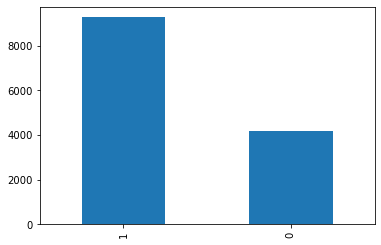

In [25]:
df_nature_label['label'].value_counts().plot(kind='bar')

In [26]:
# nltk.download('words')
words = set(nltk.corpus.words.words())

In [27]:
def preprocess_text(my_text):
    """
    Take in column (pandas series) of text and return 'cleaned' text
    
    Input: column of text
    Output: column of cleaned text
    """
    new_text = []
    
    alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
    
    alpha_lower = my_text.map(alphanumeric).map(punc_lower)
    
    for item in alpha_lower:
        new_text.append(" ".join(w for w in nltk.wordpunct_tokenize(item) if w.lower() in words or not w.isalpha()))
        
    return new_text

In [28]:
df_nature_label['clean_text'] = preprocess_text(df_nature_label['text'])

e:\Users\user\anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [54]:
df_nature_label

,text,label,engages,likes,retweets,usFlwrs,clean_text,processed_text
69430,Switzerland https://t.co/HKTmJPPZt1,0,1904,1492,412,104918,t,switzerland
69802,OMG 😍 This app analyzes call/text logs for any...,0,45,40,5,93,😍 this call text for any phone number 👉 search...,omg app analyzes call text logs phone number s...
69803,OMG 😍 This app analyzes call/text logs for any...,0,92,66,26,93,😍 this call text for any phone number 👉 search...,omg app analyzes call text logs phone number s...
69858,OMG 😍 This app analyzes call/text logs for any...,0,84,60,24,129,😍 this call text for any phone number 👉 search...,omg app analyzes call text logs phone number s...
69859,OMG 😍 This app analyzes call/text logs for any...,0,63,45,18,129,😍 this call text for any phone number 👉 search...,omg app analyzes call text logs phone number s...
...,...,...,...,...,...,...,...,...
785226,American pikas are small N. American mammals t...,1,425,336,89,447142,are small n that inhabit rocky at high during ...,american pikas small n american mammals inhabi...
785227,Severe droughts parched western North America ...,1,532,423,109,23069242,severe western north of ago a new analysis thr...,severe droughts parched western north america ...
785481,The U.S. West Coast seafloor is home to many h...,1,124,83,41,346803,the u s west coast is home to many from coral ...,u west coast seafloor home many habitats coral...
785722,Sneezewort (Achillea ptarmica). Its Latin name...,1,35,32,3,18,sneezewort its name is derived from the sneeze...,sneezewort achillea ptarmica latin name derive...


In [44]:
more_words = ['rt', 'rts', 'retweet']
s_words = set().union(stopwords.words('english'), more_words)

In [46]:
df_nature_label['processed_text'] = df_nature_label['text'].str.lower()\
          .str.replace('(@[a-z0-9]+)\w+',' ')\
          .str.replace('(http\S+)', ' ')\
          .str.replace('([^0-9a-z \t])',' ')\
          .str.replace(' +',' ')\
          .apply(lambda x: [i for i in x.split() if not i in s_words])

e:\Users\user\anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
df_nature_label['processed_text'] = df_nature_label['processed_text'].apply(" ".join)

e:\Users\user\anaconda3\envs\metis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [50]:
df_nature_label['processed_text']

69430                                           switzerland
69802     omg app analyzes call text logs phone number s...
69803     omg app analyzes call text logs phone number s...
69858     omg app analyzes call text logs phone number s...
69859     omg app analyzes call text logs phone number s...
                                ...                        
785226    american pikas small n american mammals inhabi...
785227    severe droughts parched western north america ...
785481    u west coast seafloor home many habitats coral...
785722    sneezewort achillea ptarmica latin name derive...
785723    pine martens made early morning raid feeder ne...
Name: processed_text, Length: 13469, dtype: object

In [51]:
df_nature_label['processed_text'].duplicated()

69430     False
69802     False
69803      True
69858      True
69859      True
          ...  
785226    False
785227    False
785481    False
785722    False
785723    False
Name: processed_text, Length: 13469, dtype: bool

In [52]:
bool_series = df_nature_label['processed_text'].duplicated()

In [53]:
df_nature_label[~bool_series]

,text,label,engages,likes,retweets,usFlwrs,clean_text,processed_text
69430,Switzerland https://t.co/HKTmJPPZt1,0,1904,1492,412,104918,t,switzerland
69802,OMG 😍 This app analyzes call/text logs for any...,0,45,40,5,93,😍 this call text for any phone number 👉 search...,omg app analyzes call text logs phone number s...
69860,Amazing South Africa 😍 https://t.co/0wnRYgY70d,0,395,294,101,161635,amazing south 😍 t,amazing south africa
69995,DON'T TRUST https://t.co/aQU5HF9B1b,0,571,403,168,173022,don t trust t,trust
70388,"Sunset on palouse, Washington https://t.co/zuj...",1,66,58,8,67914,sunset on t,sunset palouse washington
...,...,...,...,...,...,...,...,...
785226,American pikas are small N. American mammals t...,1,425,336,89,447142,are small n that inhabit rocky at high during ...,american pikas small n american mammals inhabi...
785227,Severe droughts parched western North America ...,1,532,423,109,23069242,severe western north of ago a new analysis thr...,severe droughts parched western north america ...
785481,The U.S. West Coast seafloor is home to many h...,1,124,83,41,346803,the u s west coast is home to many from coral ...,u west coast seafloor home many habitats coral...
785722,Sneezewort (Achillea ptarmica). Its Latin name...,1,35,32,3,18,sneezewort its name is derived from the sneeze...,sneezewort achillea ptarmica latin name derive...


In [55]:
df_processed = df_nature_label[~bool_series]

In [56]:
X = df_processed['processed_text'].to_numpy()
y = df_processed['label'].to_numpy()

In [57]:
X.shape

(12261,)

In [58]:
X[:5]

array(['switzerland',
       'omg app analyzes call text logs phone number search call app store',
       'amazing south africa', 'trust', 'sunset palouse washington'],
      dtype=object)

In [59]:
y.shape

(12261,)

In [60]:
y[:5]

array([0, 0, 0, 0, 1], dtype=int64)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [62]:
X_train

array(['sure weekend come along one 30dayswild big wild weekend events wildlife walks identification events music festivals storytelling much see whatever weather',
       'new british nature guide logo thought keep message simple put black white ourworldisworthsaving every living thing calls home',
       'finally ran canela 2 months seeing', ...,
       'earthday great see un special envoy climate action provide additional 5 5 million filling gap federal funding ensuring u climate leadership continues',
       'thanks playing along neptune wee new moon given name hippocamp spacesaturday',
       'heather shieldbug rhacognathus punctatus striking teneral nymph insect 2 5 hours later found attendee field cricket training yesterday lord piece'],
      dtype=object)

In [63]:
X_train.shape

(8214,)

In [64]:
type(X_train)

numpy.ndarray

In [65]:
y_train

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [66]:
y_train[:100]

array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1], dtype=int64)

In [67]:
np.unique(y_train)

array([0, 1], dtype=int64)

In [68]:
print("Samples per class (training): {}".format(np.bincount(y_train)))

Samples per class (training): [2535 5679]


In [69]:
print("Number of documents in test data: {}".format(len(X_test)))
print("Samples per class (test): {}".format(np.bincount(y_test)))

Number of documents in test data: 4047
Samples per class (test): [1217 2830]


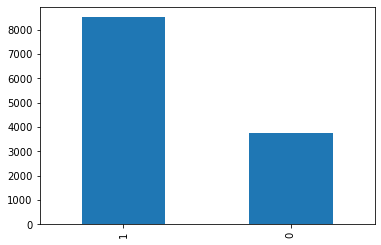

In [70]:
df_processed['label'].value_counts().plot(kind='bar')

### CountVectorizer

In [71]:
vect = CountVectorizer().fit(X_train)

In [72]:
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [73]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 20010 to 20030:\n{}".format(feature_names[20010:20030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

Number of features: 16747
First 20 features:
['00', '000', '000kg', '001', '0020', '00pm', '015833', '018', '0191', '01929', '02', '03', '04', '045325', '0458', '05', '0580', '058101', '05pm', '06']
Features 20010 to 20030:
[]
Every 2000th feature:
['00', 'bitcoin', 'currents', 'foragingfriday', 'jays', 'nbnawards19', 'ravage', 'square', 'wagtail']


In [74]:
X_train_vect = vect.transform(X_train)
print("X_train:\n{}".format(repr(X_train_vect)))

X_train:
<8214x16747 sparse matrix of type '<class 'numpy.int64'>'
	with 93279 stored elements in Compressed Sparse Row format>


In [75]:
scores = cross_val_score(LogisticRegression(max_iter=5000), X_train_vect, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.76


In [76]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5)
grid.fit(X_train_vect, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.76
Best parameters:  {'C': 1}


In [77]:
X_test_vect = vect.transform(X_test)
print("Test score: {:.2f}".format(grid.score(X_test_vect, y_test)))

Test score: 0.77


#### Count Vectorizer: min_df=5

In [78]:
vect_min5 = CountVectorizer(min_df=5).fit(X_train)
X_train_vect_min5 = vect_min5.transform(X_train)
print("X_train with min_df: {}".format(repr(X_train_vect_min5)))

X_train with min_df: <8214x3580 sparse matrix of type '<class 'numpy.int64'>'
	with 72788 stored elements in Compressed Sparse Row format>


In [79]:
feature_names_min5 = vect_min5.get_feature_names()

print("First 50 features:\n{}".format(feature_names_min5[:50]))
print("Features 20010 to 20030:\n{}".format(feature_names_min5[20010:20030]))
print("Every 700th feature:\n{}".format(feature_names_min5[::700]))

First 50 features:
['000', '07', '0710', '10', '100', '10p', '11', '110', '12', '13', '14', '15', '150', '16', '17', '18', '180', '19', '19th', '1st', '20', '200', '2009', '2015', '2016', '2017', '2018', '2019', '2020', '2030', '2050', '21', '22', '23', '24', '25', '250', '27', '28', '29', '2nd', '2pm', '30', '300', '30dayswild', '30pm', '31', '32', '33', '35']
Features 20010 to 20030:
[]
Every 700th feature:
['000', 'concern', 'goodnight', 'narrow', 'services', 'winning']


In [80]:
grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5)
grid.fit(X_train_vect_min5, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.75


### TF-IDF Vectorizer

In [81]:
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None),
                     LogisticRegression(max_iter=5000))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.75


In [82]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# transform the training dataset:
X_train_vect = vectorizer.transform(X_train)
# find maximum value for each of the features over dataset:
max_value = X_train_vect.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# get feature names
feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['photographer' 'learn' 'tell' 'ig' '30dayswild' 'blueplanetlive' 'via'
 'small' 'twitternaturecommunity' '10' 'shot' 'worldbutterflyfest'
 'findyourpark' 'animalerlive' 'red' 'tonight' 'ago' 'scientists' 'thanks'
 'earthcapture']
Features with highest tfidf: 
['sharks' 'tit' 'squid' 'bull' 'litter' 'duck' 'monk' 'deep' 'news'
 'thistle' 'transportation' 'istanbul' 'girl' 'electric' 'step' 'sheep'
 'giraffe' 'volcano' 'horn' 'cleaner']


In [83]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['one' 'wildlife' 'nature' 'today' 'new' 'world' 'day' 'help' 'like'
 'species' 'us' 'see' 'time' 'ourworldisworthsaving' 'year' 'get' 'photo'
 'beautiful' 'first' 'water' 'sea' 'great' 'people' 'earth' 'find' 'live'
 'know' 'years' 'life' 'wild' 'make' 'learn' 'photographer' 'could' 'look'
 'last' 'take' 'little' 'climate' 'plastic' 'garden' 'around' 'national'
 'planet' 'ocean' 'animals' 'week' 'good' 'protect' 'need' 'tell' 'change'
 'ig' 'oceans' 'many' 'marine' 'love' 'found' 'birds' '30dayswild'
 'amazing' 'two' 'blue' 'use' 'photos' 'blueplanetlive' 'way' 'may' 'work'
 'uk' 'seen' 'go' 'would' 'park' 'conservation' 'best' 'back' 'watch'
 'morning' 'via' 'butterflies' 'act' 'small' 'every' 'also' 'much' 'long'
 'across' 'join' 'home' 'twitternaturecommunity' '10' 'shot' 'food'
 'right' 'science' 'butterfly' 'worldbutterflyfest' 'happy' 'findyourpark']


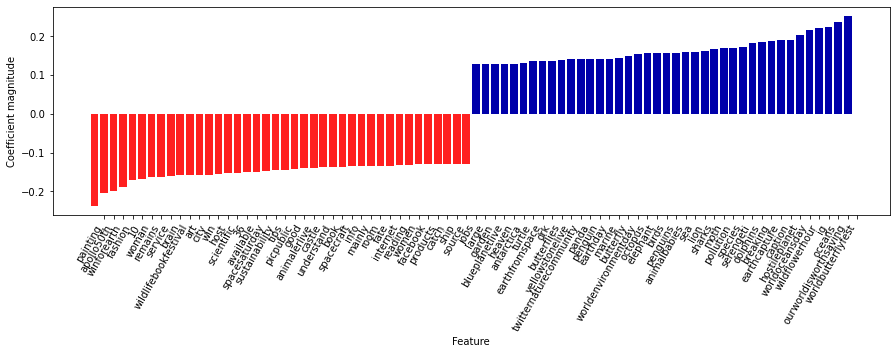

In [84]:
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_,
    feature_names, n_top_features=40)

max_iter=5000

In [85]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
# param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
#               "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

param_grid = {'logisticregression__C': [1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.75
Best parameters:
{'logisticregression__C': 1, 'tfidfvectorizer__ngram_range': (1, 2)}


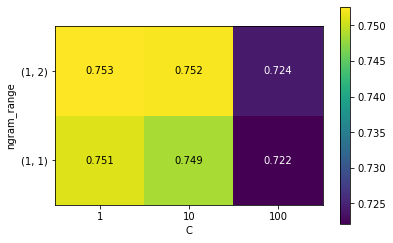

In [86]:
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 2).T
# visualize heat map
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

In [ ]:
# # extract scores from grid_search
# scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# # visualize heat map
# heatmap = mglearn.tools.heatmap(
#     scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
#     xticklabels=param_grid['logisticregression__C'],
#     yticklabels=param_grid['tfidfvectorizer__ngram_range'])
# plt.colorbar(heatmap)

(-22.0, 22.0)

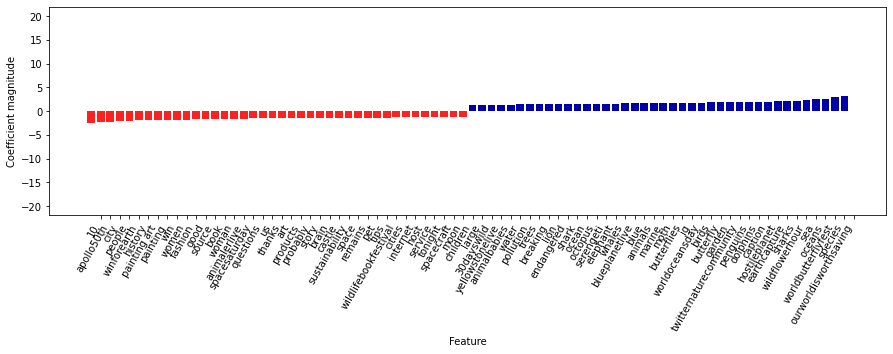

In [87]:
# extract feature names and coefficients
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)
plt.ylim(-22, 22)

(-22.0, 22.0)

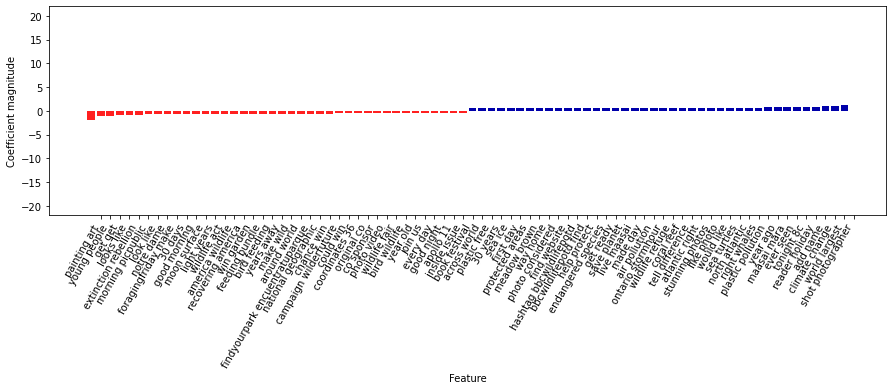

In [88]:
# find 2-gram features
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 2
# visualize only 2-gram features
mglearn.tools.visualize_coefficients(coef.ravel()[mask],
                                     feature_names[mask], n_top_features=40)
plt.ylim(-22, 22)

In [89]:
y_pred = grid.best_estimator_.predict(X_train)

In [90]:
print(confusion_matrix(y_train, y_pred))

[[1382 1153]
 [ 150 5529]]


In [91]:
score_train = f1_score(y_train, y_pred, average = 'binary')
print('F-Measure: %.3f' % score_train)

F-Measure: 0.895


In [92]:
y_test_pred = grid.best_estimator_.predict(X_test)

In [93]:
print(confusion_matrix(y_test, y_test_pred))

[[ 472  745]
 [ 184 2646]]


In [94]:
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('F-Measure: %.3f' % score_test)

F-Measure: 0.851


In [95]:
actual = y_test.tolist() 
predicted = y_test_pred 
print (classification_report(actual, predicted) )

              precision    recall  f1-score   support

           0       0.72      0.39      0.50      1217
           1       0.78      0.93      0.85      2830

    accuracy                           0.77      4047
   macro avg       0.75      0.66      0.68      4047
weighted avg       0.76      0.77      0.75      4047



### Random Forest



Had an error running cell below. I didn't realize the specfic keys in param_grid:
https://stackoverflow.com/questions/64089009/how-can-i-tune-the-parameters-in-a-random-forest-classifier-inside-a-pipeline

In [96]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), RandomForestClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"tfidfvectorizer__ngram_range": [(1, 1), (1, 2)],
              "randomforestclassifier__n_estimators": [800, 1000]
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.75
Best parameters:
{'randomforestclassifier__n_estimators': 800, 'tfidfvectorizer__ngram_range': (1, 1)}


In [97]:
from IPython.lib.display import Audio

framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

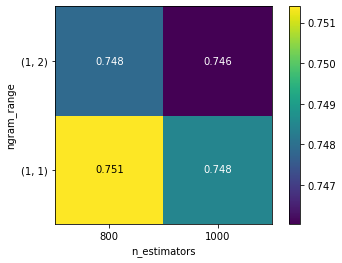

In [98]:
# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 2).T
# visualize heat map
heatmap = mglearn.tools.heatmap(
    scores, xlabel="n_estimators", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['randomforestclassifier__n_estimators'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

#### Had to use feature_importances_ for Random Forest Classifier
https://towardsdatascience.com/present-the-feature-importance-of-the-random-forest-classifier-99bb042be4cc

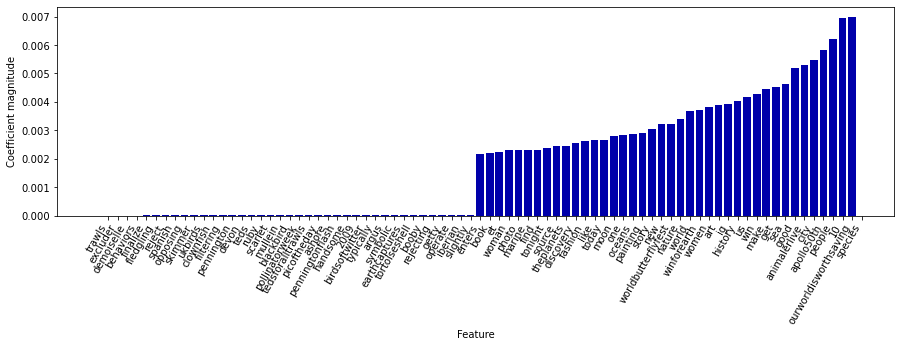

In [99]:
# extract feature names and feature_importances
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
feature_importances = grid.best_estimator_.named_steps['randomforestclassifier'].feature_importances_
mglearn.tools.visualize_coefficients(feature_importances, feature_names, n_top_features=40)


In [69]:
feature_importances

array([9.10682045e-06, 5.62131447e-04, 3.01885125e-05, ...,
       1.08366804e-04, 5.58253380e-05, 8.71436261e-05])

In [103]:
y_pred = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))
score_train = f1_score(y_train, y_pred, average = 'binary')
print('F-Measure: %.3f' % score_train)

[[2510   25]
 [   7 5672]]
F-Measure: 0.997


In [104]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('F-Measure: %.3f' % score_test)

[[ 564  653]
 [ 331 2499]]
F-Measure: 0.836


In [105]:
actual = y_test.tolist() 
predicted = y_test_pred 
print (classification_report(actual, predicted) )

              precision    recall  f1-score   support

           0       0.63      0.46      0.53      1217
           1       0.79      0.88      0.84      2830

    accuracy                           0.76      4047
   macro avg       0.71      0.67      0.68      4047
weighted avg       0.74      0.76      0.74      4047




- n_estimators: In general the more trees the less likely the algorithm is to overfit. So try increasing this. The lower this number, the closer the model is to a decision tree, with a restricted feature set.
    
- max_features: try reducing this number (try 30-50% of the number of features). This determines how many features each tree is randomly assigned. The smaller, the less likely to overfit, but too small will start to introduce under fitting.

- max_depth: Experiment with this. This will reduce the complexity of the learned models, lowering over fitting risk. Try starting small, say 5-10, and increasing you get the best result.

- min_samples_leaf: Try setting this to values greater than one. This has a similar effect to the max_depth parameter, it means the branch will stop splitting once the leaves have that number of samples each.


In [80]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), RandomForestClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"tfidfvectorizer__ngram_range": [(1, 2)],
              "randomforestclassifier__n_estimators": [800],
              "randomforestclassifier__max_features": [10, 50, 100],
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.78
Best parameters:
{'randomforestclassifier__max_features': 100, 'randomforestclassifier__n_estimators': 800, 'tfidfvectorizer__ngram_range': (1, 2)}


In [81]:
y_pred = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))
score_train = f1_score(y_train, y_pred, average = 'binary')
print('F-Measure: %.3f' % score_train)

[[2779   55]
 [  21 6169]]
F-Measure: 0.994


In [82]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('F-Measure: %.3f' % score_test)

[[ 551  815]
 [ 147 2932]]
F-Measure: 0.859


In [83]:
actual = y_test.tolist() 
predicted = y_test_pred 
print (classification_report(actual, predicted) )

              precision    recall  f1-score   support

           0       0.79      0.40      0.53      1366
           1       0.78      0.95      0.86      3079

    accuracy                           0.78      4445
   macro avg       0.79      0.68      0.70      4445
weighted avg       0.78      0.78      0.76      4445



### XGBoost

In [106]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), XGBClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"tfidfvectorizer__ngram_range": [(1,1), (1, 2)],
              "xgbclassifier__n_estimators": [1000, 1200, 1400]
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.75
Best parameters:
{'tfidfvectorizer__ngram_range': (1, 1), 'xgbclassifier__n_estimators': 1400}


In [107]:

framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

In [108]:
y_pred = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))
score_train = f1_score(y_train, y_pred, average = 'binary')
print('F-Measure: %.3f' % score_train)

[[1573  962]
 [  87 5592]]
F-Measure: 0.914


In [109]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('F-Measure: %.3f' % score_test)

[[ 442  775]
 [ 210 2620]]
F-Measure: 0.842


In [110]:
actual = y_test.tolist() 
predicted = y_test_pred 
print (classification_report(actual, predicted) )

              precision    recall  f1-score   support

           0       0.68      0.36      0.47      1217
           1       0.77      0.93      0.84      2830

    accuracy                           0.76      4047
   macro avg       0.72      0.64      0.66      4047
weighted avg       0.74      0.76      0.73      4047



In [111]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), XGBClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"tfidfvectorizer__ngram_range": [(1,1)],
              "xgbclassifier__n_estimators": [1400, 1600],
              "xgbclassifier__max_depth": [1, 5],
              "xgbclassifier__scale_pos_weight": [1, 5]
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.75
Best parameters:
{'tfidfvectorizer__ngram_range': (1, 1), 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 1400, 'xgbclassifier__scale_pos_weight': 1}


In [112]:

framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

In [113]:
y_pred = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))
score_train = f1_score(y_train, y_pred, average = 'binary')
print('F-Measure: %.3f' % score_train)

[[1941  594]
 [  45 5634]]
F-Measure: 0.946


In [114]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('F-Measure: %.3f' % score_test)

[[ 502  715]
 [ 269 2561]]
F-Measure: 0.839


In [115]:
actual = y_test.tolist() 
predicted = y_test_pred 
print (classification_report(actual, predicted) )

              precision    recall  f1-score   support

           0       0.65      0.41      0.51      1217
           1       0.78      0.90      0.84      2830

    accuracy                           0.76      4047
   macro avg       0.72      0.66      0.67      4047
weighted avg       0.74      0.76      0.74      4047



In [116]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), XGBClassifier())
# running the grid-search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"tfidfvectorizer__ngram_range": [(1,1)],
              "xgbclassifier__n_estimators": [1400, 1600],
              "xgbclassifier__max_depth": [5, 10],
              "xgbclassifier__scale_pos_weight": [1, 2]
              }

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

Best cross-validation score: 0.75
Best parameters:
{'tfidfvectorizer__ngram_range': (1, 1), 'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 1400, 'xgbclassifier__scale_pos_weight': 1}


In [117]:

framerate = 4410
play_time_seconds = 3

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

In [118]:
y_pred = grid.best_estimator_.predict(X_train)
print(confusion_matrix(y_train, y_pred))
score_train = f1_score(y_train, y_pred, average = 'binary')
print('F-Measure: %.3f' % score_train)

[[1941  594]
 [  45 5634]]
F-Measure: 0.946


In [119]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))
score_test = f1_score(y_test, y_test_pred, average = 'binary')
print('F-Measure: %.3f' % score_test)

[[ 502  715]
 [ 269 2561]]
F-Measure: 0.839
